#### Setup

In [105]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from pandas_datareader import data as web

#### Obtenção dos dados

Período de avaliação das ações

In [118]:
start_date = datetime.datetime(2022,1,1)
end_date = datetime.datetime(2022,11,30)

Preparação das ações a serem avaliadas.

Neste caso, opções que eu conheço e que eu desejo investir

In [121]:
# houve uma alteração no retorno do yahoo finance e esta linha é necessária até que o Pandas DataReader seja corrigido.
yf.pdr_override()
#Gerdau
goau = web.get_data_yahoo(['GOAU4.SA'], start=start_date, end=end_date)
#Copel
cple = web.get_data_yahoo(['CPLE6.SA'], start=start_date, end=end_date)
# Assaí
asai = web.get_data_yahoo(['ASAI3.SA'], start=start_date, end=end_date)
#Itaú
itub = web.get_data_yahoo(['ITUB4.SA'], start=start_date, end=end_date)
#Natura
ntco = web.get_data_yahoo(['NTCO3.SA'], start=start_date, end=end_date)
#Vale
vale = web.get_data_yahoo(['VALE3.SA'], start=start_date, end=end_date)

stocks_names = ['Gerdau', 'Copel', 'Assaí', 'Itaú', 'Natura', 'Vale']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Visualizando o desempenho das ações ao longo do ano

Text(0.5, 1.0, 'Vale')

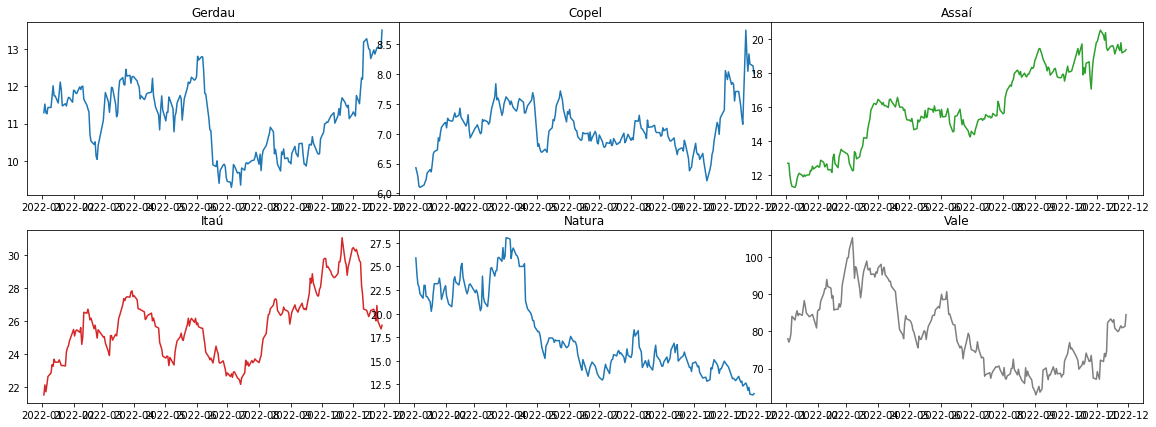

In [122]:
fig = plt.figure(figsize = (20,7))
gs = fig.add_gridspec(2, 3, wspace = 0)
(ax1, ax2, ax3), (ax4, ax5, ax6) = gs.subplots()
ax1.plot(goau['Close'])
ax1.set_title(stocks_names[0])
ax2.plot(cple['Close'], )
ax2.set_title(stocks_names[1])
ax3.plot(asai['Close'], 'tab:green')
ax3.set_title(stocks_names[2])
ax4.plot(itub['Close'], 'tab:red')
ax4.set_title(stocks_names[3])
ax5.plot(ntco['Close'], 'tab:blue')
ax5.set_title(stocks_names[4])
ax6.plot(vale['Close'], 'tab:gray')
ax6.set_title(stocks_names[5])

Unindo os dataframes com dados de cada ação.

Neste caso queremos apenas o valor de fechamento

In [123]:
# com o concat será feita a união dos dataframes. A opção axis indica que queremos os dados sejam colocados em colunas diferentes ao invés de concatenar as linhas
stocks = pd.concat([
    goau['Close'], 
    cple['Close'], 
    asai['Close'],
    itub['Close'],
    ntco['Close'],
    vale['Close']
    ],axis= 1)
# agora renomeamos as colunas para que tenham o nome de suas respectivas ações
stocks.columns = stocks_names

stocks.head(5)

,Gerdau,Copel,Assaí,Itaú,Natura,Vale
Date,,,,,,
2022-01-03,11.29,6.43,12.72,21.510000,25.900000,78.000000
2022-01-04,11.52,6.36,12.72,22.120001,24.230000,77.080002
2022-01-05,11.29,6.28,11.99,21.700001,23.110001,77.809998
2022-01-06,11.26,6.12,11.59,22.139999,22.850000,79.379997
2022-01-07,11.43,6.10,11.36,22.629999,22.110001,84.000000


#### Calculo do retorno

$$
R_t = \frac{P_t}{P_t - 1}\
$$
Onde: 
 - *R* é o retorno esperado
 - *P* é o preço
 - *P*-1 é o preço anterior

Todos os elementos são subscritos (t), ou seja, todos são em função do tempo.


In [91]:
# neste caso o shift faz o LAG do valor, ou seja, pega o valor correspondente ao dia anterior
returns = stocks / stocks.shift(1)
# vemos que os primeiros valores são inválidos pois não há uma data anterior para o cálculo
returns.head(5)

,Gerdal,Copel,Assaí,Itaú,Natura,Vale
Date,,,,,,
2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,1.020372,0.989114,1.000000,1.028359,0.935521,0.988205
2022-01-05,0.980035,0.987421,0.942610,0.981013,0.953776,1.009471
2022-01-06,0.997343,0.974522,0.966639,1.020276,0.988749,1.020177
2022-01-07,1.015098,0.996732,0.980155,1.022132,0.967615,1.058201


Padronização dos valores

Como temos escalas diferentes nos valores nas ações, precisamos padronizá-los. Para isso usaremos a função log que colocará os valores em uma escala de -1 a 1

A fórmula neste caso é:

$$
{log r_t} = {log} \frac{P_t}{P_T -1}\
$$

In [92]:
log_returns = np.log(returns)
# podemos ver que agora os valores, que antes oscilavam entre R$ 6 (CPLE) e R$ 21 (ITUB), agora oscilam entre -1 e 1
log_returns.head(5)

,Gerdal,Copel,Assaí,Itaú,Natura,Vale
Date,,,,,,
2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,0.020167,-0.010946,0.000000,0.027964,-0.066651,-0.011865
2022-01-05,-0.020167,-0.012658,-0.059103,-0.019170,-0.047326,0.009426
2022-01-06,-0.002661,-0.025808,-0.033930,0.020074,-0.011314,0.019976
2022-01-07,0.014985,-0.003273,-0.020044,0.021891,-0.032921,0.056570


#### Sharpe ratio

Este índice considera o retorno de acordo com o risco envolvido, utilizando dados históricos

$$
SR(w) = \frac{R(w)-R_f}{\sigma(w)}\
$$
Onde 
 - SR é o Sharpe Ratio, o valor que desejamos obter
 - (w) é o peso de cada ação. Neste caso o valor normalizado de todos os os valores de nossa lista, ou seja, ao somar todos os valores teremos 1 como resultado. Esse valor irá ajudar a definir o percential de nosso investimento em cada ação. Neste exemplo, w1 é GOAU, w2 é CPLE e assim por diante
 - R(f) é o retorno caso não exista risco, e como veremos mais adiante é um valor despresado, não precisaremos dele.
 - Sigmna é desvio padrão ou volatilidade

*w* é a soma dos pesos dentro de um determinado dia

$$
(w) = [w_1 \ \ w_2 \ \ w_3 \ \ w_4 \ \ w_5]
$$

*R(w)* - retorno do inverstimento: matriz transposta dos pesso multiplicado pelo valor do dia anterior (log)

$$
R(w) = w^t\ log(r)
$$

*sigma(w)* - risco do investimento é a raiz da matriz transposta de pesos  multiplicado pela soma dos pesos 

$$
{\sigma(w)} = \sqrt{w^t\sum\nolimits_{}^{}{w}}\
$$

Ao final teremos a formula que será utilizada:
$$
SR(w) ~ \frac{w^t log(r)}{\sqrt{w^t\sum\nolimits_{}^{}{w}}}\
$$



Calculando o retorno vs volatilidade

Neste caso avaliaremos 10000 diferentes portfólios, gerando peso aleatórios para todos para cada uma das ações

In [93]:
number_of_portfolios = 10000
number_of_stocks = len(stocks.columns)

# vamos criar os vetores que serão utilizados e iniciá-los com zero
weights = np.zeros((number_of_portfolios, number_of_stocks))
expected_return = np.zeros(number_of_portfolios)
expected_volatility = np.zeros(number_of_portfolios)
sharpe_ratio = np.zeros(number_of_portfolios)

# Como utilizaremos a média dos retornos padromizados (log_returns), vamos calculá-la agora para evitar 
# processamento excessivo durante o loop
mean_log_returns = log_returns.mean()

# utilizaremos a matriz de covariancia (grau de interdependência) entre as ações de nossa base
sigma = log_returns.cov()

# vamos correr todo o portfólio, quanto maior o número de iterações maior a quantidade combinações a serem feitas
for i in range(number_of_portfolios):
    
    # (w)
    # criar vetor com pesos aleatórios, usado em cada uma das iterações
    w = np.array(np.random.random(number_of_stocks))
    # encontra o percentual de cada peso gerado anteriormente
    w = w / np.sum(w)
    
    # salva o valor dentro da matriz
    weights[i,:] = w
    
    # R(w)
    # calcular o log return multiplicando o valor com LAG pelo peso. Esta matriz terá apenas uma coluna, com o retorno
    # esperado para aquele dia de todas as açoes da carteira
    expected_return[i] = np.sum(mean_log_returns * w)

    # sigma(w)
    expected_volatility[i] = np.sqrt(
        np.dot(
            w.T,
            np.dot(sigma, w)
        )
    )

    # Sharpe ratio, o retorno dividido pela volatilidade
    sharpe_ratio[i] = expected_return[i] / expected_volatility[i]

#### Maximização do Sharpe Ratio

Retorna o maior sharpe ratio calculado de acordo com os dados disponívei

In [94]:
# retorna a posição que garante o maior retorno nas ações de acordo com o sharpe ratio
max_index = sharpe_ratio.argmax()

# agora podemos ver qual o percentual de nosso orçamento que podemos alocar em cada uma das ações para maximizar nosso retorno.
weights[max_index, :]

array([0.22518161, 0.23005962, 0.5021496 , 0.03250748, 0.00709855,
       0.00300315])

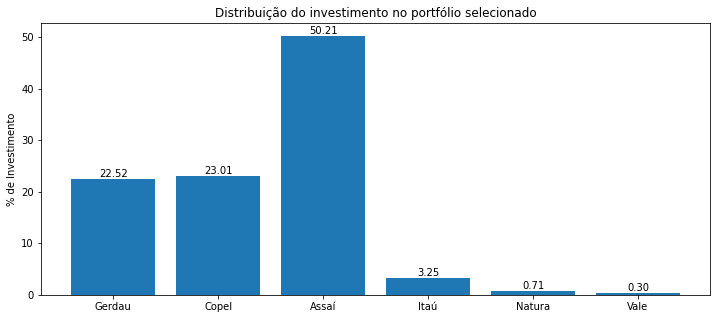

In [125]:
plt.figure(figsize=(12,5))
hbars = plt.bar(
    x = stocks_names, 
    height=weights[max_index, :] * 100
)
plt.bar_label(hbars, fmt='%.2f')
plt.ylabel('% de Investimento')
plt.title('Distribuição do investimento no portfólio selecionado')
plt.show()

Segundo o Sharpe Ratio devemos investir 54% de nosso orçamento em ações do Assai (ASAI) e menos de 1% nas ações da Natura (NTCO).

O interessante deste modelo é que ele pode ser aplica à praticamente qualquer carteira, desde que se tenha dados históricos em um mesmo período de todas as ações dela

#### Visualização dos dados caluclados

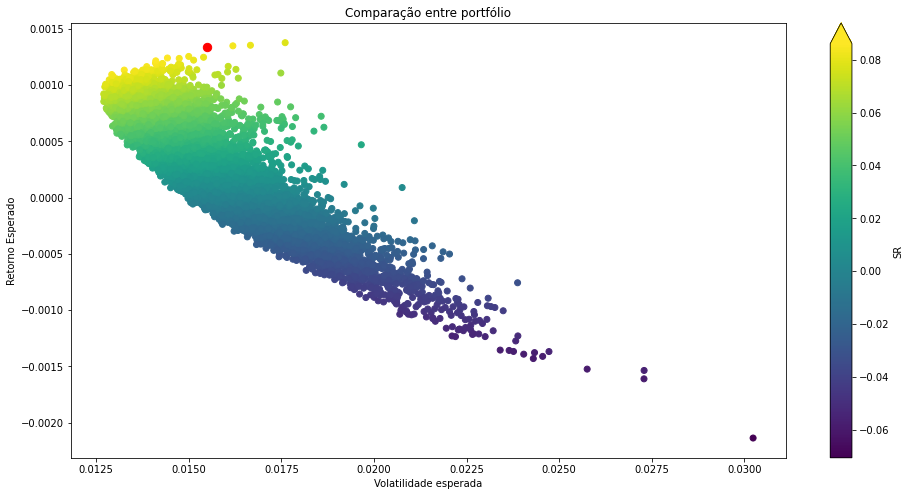

In [126]:
plt.figure(figsize=(16,8))
# plota a volatilidade e o retorno classificado de acordo com o maior valor do Sharpe Ratio
plt.scatter(
    expected_volatility, 
    expected_return, 
    c=sharpe_ratio
)
plt.xlabel('Volatilidade esperada')
plt.ylabel('Retorno Esperado')
plt.title('Comparação entre portfólio')
plt.colorbar(label = 'SR', extend = 'max')
# plota em vermelho o max_index, ou seja, o ponto de maior retorno e menor risco
plt.scatter(
    expected_volatility[max_index], 
    expected_return[max_index], 
    c='red', 
    s=70,   
)
plt.show()

Podemos observar no gráfico acima que os maiores retornos (em amarelo) estão no limite superior de nossa amostra, e cabe ao investidor avaliar o risco (eixo X) que deseja correr para alcançar aquele retorno.

O ponto vermelho indica o maior retorno que podemos ter com o menor risco possível.

#### Criação do melhor portfólio, ou o Efficient Markowitz Frontier

Agora vamos calcular, para cada cenário de retorno o risco ao qual estaremos expostos. Essa área é conhecida como fronteira eficiente de Markowitz.

Para saber mais seu conceito, recomendo a leitura do texto do Erik Kawano no link: http://clubedefinancas.com.br/materias/fronteira-eficiente/

In [83]:
# função que retorno o sharpe ratio negativo de um determinado peso
def negative_sharpe_ratio(weight):
    weight = np.array(weight)
    return_ = np.sum(mean_log_returns * weight)
    volatility_ = np.sqrt(np.dot(weight.T, np.dot(sigma, weight)))
    sharpe_ratio_ = return_ / volatility_
    return -1 * sharpe_ratio_

def check_sum_to_one(weight):
    return np.sum(weight) - 1

# peso inicial, valores iguais para todos os elementos
w0 = ([1/len(stocks.columns)]) * len(stocks.columns)

def get_return(weight):
    weight = np.array(weight)
    return np.sum(mean_log_returns * weight)

bounds = ([(0,1)])*len(stocks.columns)


In [98]:
returns = np.linspace(0, np.max(expected_return), 25)
volatility_opt = []

# função para minimizar a volatilidade
def minimize_volatility(weight):
    weight = np.array(weight)
    return np.sqrt(np.dot(weight.T, np.dot(sigma, weight)))
    
# faremos um loop nos valores de retorno buscando o menor risco possível ou a volatilidade ótima (volatility_opt)
# para isso uzaremos a função minimize do pacote scipy
for r in returns:
    #encontrar melhor volatilidade
    constraints = (
        {'type':'eq', 'fun':check_sum_to_one},
        {'type':'eq', 'fun': lambda weight: get_return(weight) - r}
    )
    opt = minimize(minimize_volatility, w0, 
       method='SLSQP', 
        bounds=bounds, 
        constraints = constraints
    )

    volatility_opt.append(opt['fun'])


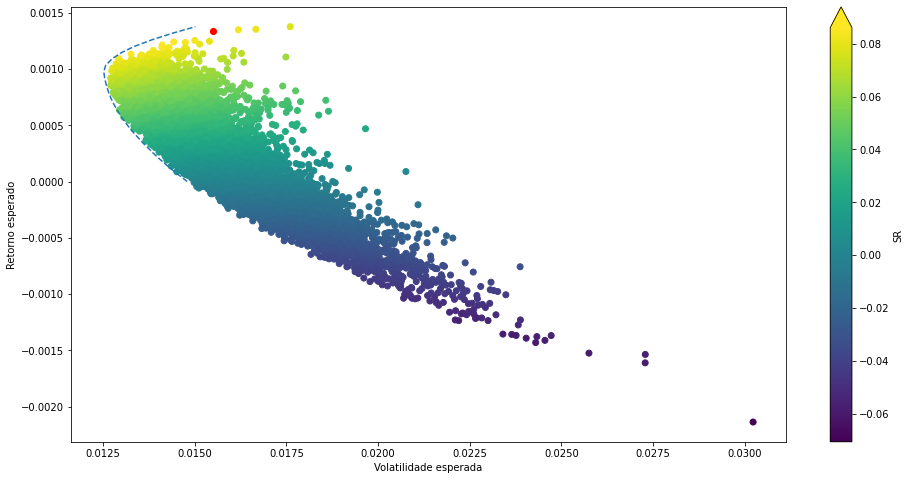

In [99]:
plt.figure(figsize=(16,8))
# plota a volatilidade e o retorno classificado de acordo com o maior valor do Sharpe Ratio
plt.scatter(expected_volatility, expected_return, c=sharpe_ratio)
plt.xlabel('Volatilidade esperada')
plt.ylabel('Retorno esperado')
plt.colorbar(label = 'SR', extend = 'max')
# plota em vermelho o max_index, ou seja, o ponto de maior retorno e menor risco
plt.scatter(expected_volatility[max_index], expected_return[max_index], c='red')
plt.plot(volatility_opt, returns, '--')
plt.show()

Podemos observar que os valores com melhor retorno estão no limite onde o retorno é maior vs o risco.

Não de estranhar que o ponto de maior retorno (em vermelho) está exatamente sobre a fronteira (linha pontilhada)

In [104]:
print(volatility_opt)

[0.014793021550468716, 0.0145641066790499, 0.014344979961616692, 0.014135789094872323, 0.01393778497374737, 0.013759449688085785, 0.013582129804828787, 0.01342022339228134, 0.013262610550020398, 0.013124539211328223, 0.012999406326541313, 0.01288759517909048, 0.012789435020716316, 0.012705534351023375, 0.012636201595287012, 0.01258177870277968, 0.01254153817978766, 0.012516689644268632, 0.012566374971002471, 0.012738546530572983, 0.013002695678296924, 0.013375395404046716, 0.013845838315994417, 0.014397947673681074, 0.015017439013124094]
